In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import time
%pylab inline
plt.style.use('seaborn-dark')

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
folder_loc = '2020-03-13/Spec Sweep Noisy 170 v2/'
file_loc = '2020-03-13-21-53_noisy170_spec001.dat'
dat_spec = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat_spec = np.concatenate((dat_spec,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [3]:
cur = dat_spec[:,0]
geo = dat_spec[:,1]
speaker = dat_spec[:,2]
bias_mod = dat_spec[:,4]
bias = dat_spec[:,5]
Z = dat_spec[:,8]
LIY = dat_spec[:,10]

t = linspace(0,len(cur)/10000,len(cur))
print(len(cur),len(t),shape(dat_spec))

2475000 2475000 (2475000, 11)


324


(0, 25)

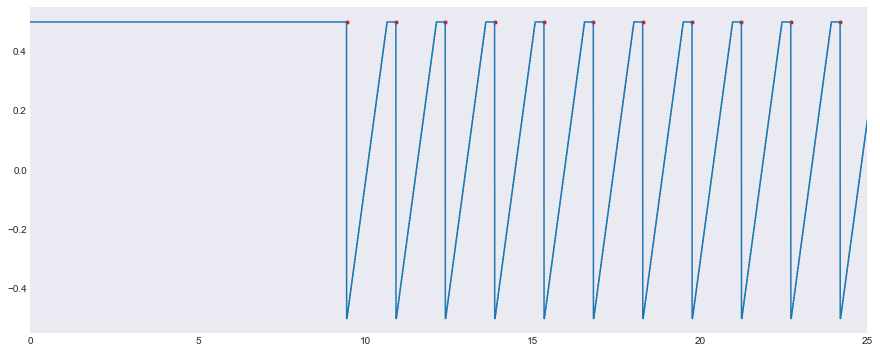

In [4]:
figsize(15,6)
dt = t[1]
grad = np.gradient(bias,dt)
brk_pnt = np.argsort(grad)[:600]
count = 0
for j in brk_pnt:
    if grad[j] < -1000:
        count = count+1
print(count)

brk_pnt = np.argsort(grad)[:count]
brk_pnt = np.sort(brk_pnt)
# print(brk_pnt)
for idx,point in enumerate(brk_pnt):
    temp_pnt = point
    brk_pnt[np.where(absolute(brk_pnt-point)<10)] = 0
    brk_pnt[idx] = point
brk_pnt = np.sort(brk_pnt[brk_pnt != 0])
# brk_pnt = np.append(brk_pnt,-1)
# print(brk_pnt)
plot(t[brk_pnt],bias[brk_pnt],'r.')
plot(t,bias)
# plot(t,grad)
start = 0
xlim(start,start+25)
# ylim(-5009,-4900)

In [5]:
start = brk_pnt[0]+1
end = brk_pnt[-1]

cur_cut = dat_spec[:start,0]
geo_cut = dat_spec[:start,1]
speaker_cut = dat_spec[:start,2]
bias_mod_cut = dat_spec[:start,4]
bias_cut = dat_spec[:start,5]
Z_cut = dat_spec[:start,8]
LIY_cut = dat_spec[:start,10]

t = linspace(0,len(cur_cut)/10000,len(cur_cut))
print(len(cur_cut),len(t))

94405 94405


(0, 20)

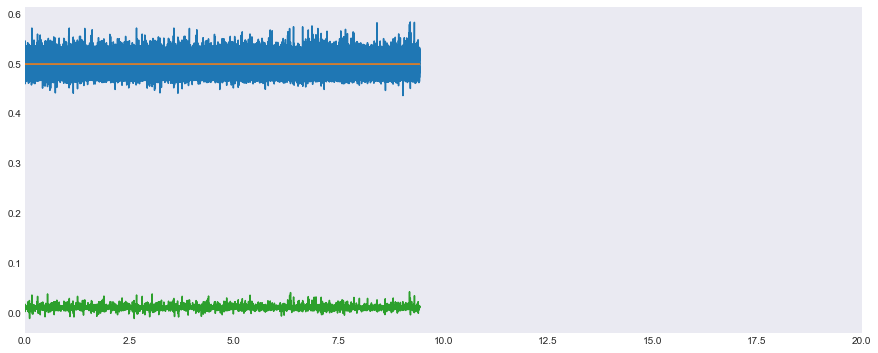

In [7]:
plot(t,cur_cut*5e8)
plot(t,bias_cut)
plot(t,LIY_cut*5e8)
xlim(0,20)

In [12]:
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective
# Z_fit = fit_cancel(Z_cut)
# plot(t,Z_cut)
# plot(t,Z_cut)

In [6]:
folder_loc = '2020-03-13/Noisy Calibration Lockin 170/'
file_loc = '2020-03-13-21-40_noisy170_lockin_cal001.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat = np.concatenate((dat,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [7]:
cur_cal = dat[:,0]
geo_cal = dat[:,1]
bias_mod_cal = dat[:,4]
bias_cal = dat[:,5]
Z_cal = dat[:,8]
LIY_cal = dat[:,10]

t = linspace(0,len(cur_cal)/10000,len(cur_cal))
print(len(geo_cal),len(t))

7777400 7777400


RMS Calibration: 0.024022724981012426
RMS Sweep: 0.023719648853659098


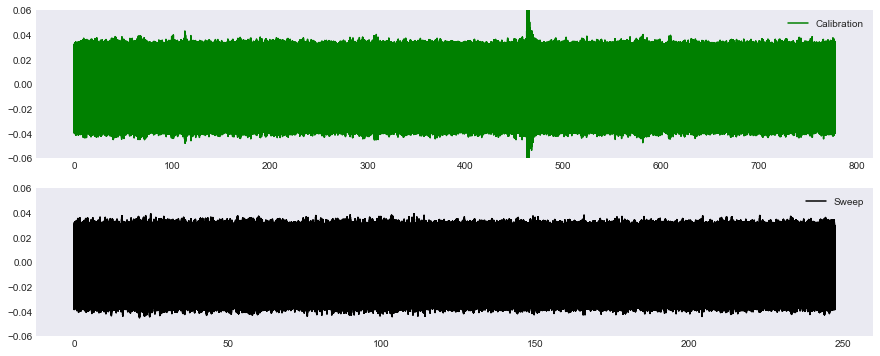

In [69]:
fig,ax = subplots(2,1)
ax[0].plot(t,geo_cal,'g',label='Calibration')
t_temp= linspace(0,len(dat_spec[:,1])/10000,len(dat_spec[:,1]))
ax[1].plot(t_temp,dat_spec[:,1],'k',label='Sweep')
ax[0].set_ylim(-0.06,0.06)
# ax[0].set_xlim(0,400)
ax[0].legend(loc=1)
ax[1].set_ylim(-0.06,0.06)
ax[1].legend(loc=1)
print('RMS Calibration:', sqrt(mean(geo_cal**2)))
print('RMS Sweep:', sqrt(mean(dat_spec[:,1]**2)))

In [13]:
n = 10000
segs = np.zeros(((len(geo_cal[0:80000]))//(n),n),dtype=np.complex)
seg_Z = np.zeros(((len(Z_cal[0:80000]))//(n),n),dtype=np.complex)
segs_sweep = np.zeros(((len(dat_spec[:80000,1]))//(n),n),dtype=np.complex)
seg_Z_sweep = np.zeros(((len(dat_spec[0:80000,8]))//(n),n),dtype=np.complex)
geo_cal_temp = np.copy(geo_cal[0:80000])
geo_sweep_temp = np.copy(dat_spec[:80000,1])
Z_cal_temp = np.copy(Z_cal[0:80000])
Z_sweep_temp = np.copy(dat_spec[:80000,8])
j = 0
while len(geo_cal_temp) >= n:
    segs[j,:] = fit_cancel(geo_cal_temp[:n])
    seg_Z[j,:] = fit_cancel(Z_cal_temp[:n])
    j+=1
    geo_cal_temp=geo_cal_temp[n:]
    Z_cal_temp = Z_cal_temp[n:]
j=0
while len(geo_sweep_temp) >= n:
    segs_sweep[j,:] = fit_cancel(geo_sweep_temp[:n])
    seg_Z_sweep[j,:] = fit_cancel(Z_sweep_temp[:n])
    j+=1
    geo_sweep_temp=geo_sweep_temp[n:]
    Z_sweep_temp=Z_sweep_temp[n:]
for i in range(0,len(segs[:,0])):
    segs[i,:] = np.fft.fft(segs[i,:])
    seg_Z[i,:] = np.fft.fft(seg_Z[i,:])
for i in range(0,len(segs_sweep[:,0])):
    segs_sweep[i,:] = np.fft.fft(segs_sweep[i,:])
    seg_Z_sweep[i,:] = np.fft.fft(seg_Z_sweep[i,:])
segs = mean(segs,axis=0)
seg_Z = mean(seg_Z,axis=0)
segs_sweep = mean(segs_sweep,axis=0)
seg_Z_sweep = mean(seg_Z_sweep,axis=0)
freqs = np.fft.fftfreq(len(segs),1/10000)

print(shape(segs),shape(segs_sweep),shape(seg_Z),shape(seg_Z_sweep))

(10000,) (10000,) (10000,) (10000,)


(1e-06, 10000.0)

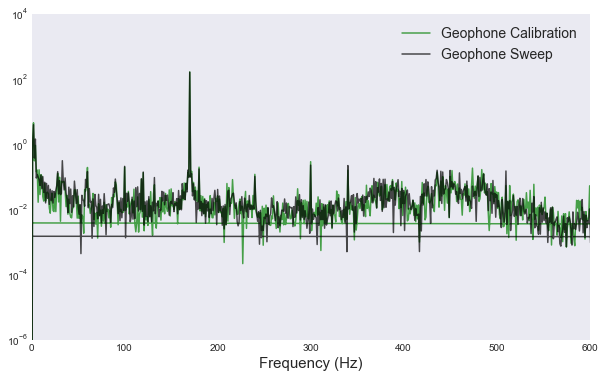

In [139]:
semilogy(freqs,absolute(segs),'g',label='Geophone Calibration',alpha=0.7)
semilogy(freqs,absolute(segs_sweep),'k',label='Geophone Sweep',alpha=0.7)
legend(loc=1,fontsize=14)
xlabel('Frequency (Hz)',size=15)
xlim(0,600)
ylim(1e-6,1e4)

(0, 600)

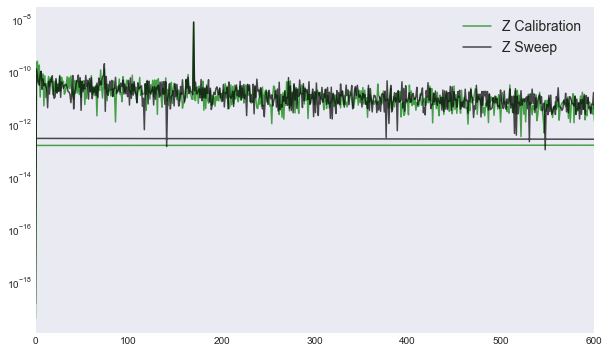

In [140]:
semilogy(freqs,absolute(seg_Z),'g',label='Z Calibration',alpha=0.7)
semilogy(freqs,absolute(seg_Z_sweep),'k',label='Z Sweep',alpha=0.7)
legend(loc=1,fontsize=14)
xlim(0,600)
# ylim(1e-6,1e4)

In [32]:
print(102//10,102/10)

10 10.2


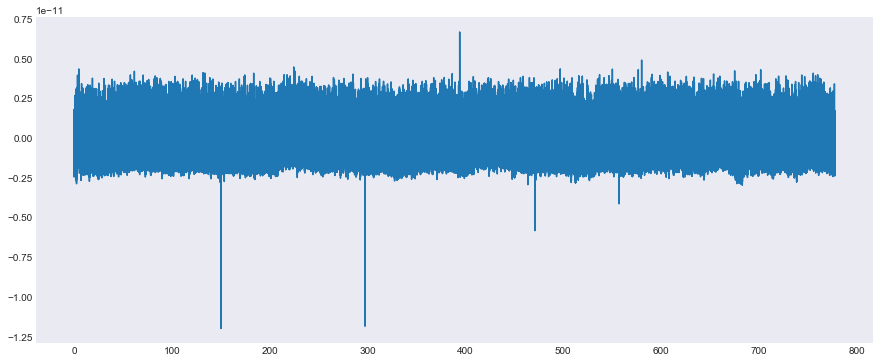

In [11]:
plot(t,fit_cancel(Z_cal,n=10))

(0, 200)

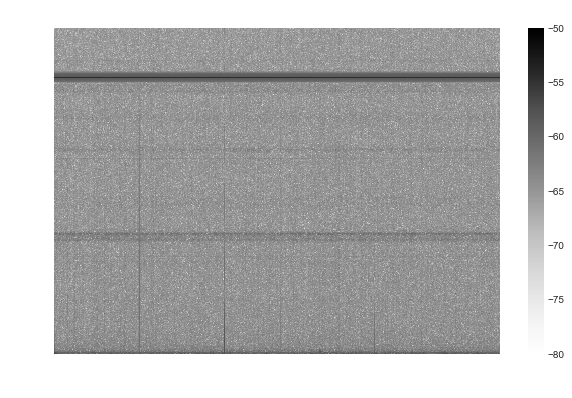

In [12]:
# Z_fft = np.fft.fft(fit_cancel(Z_cal,n=10))
# freqs = np.fft.fftfreq(len(Z_cal),1/10000)
# semilogy(freqs,Z_fft)
# xlim(0,600)

fig,ax =subplots(1,1,figsize=(10,6))
fs = 10000
f, t, Sxx = signal.spectrogram(fit_cancel(Z_cal,n=10), fs,nperseg=20000)
# f, t, Sxx = signal.spectrogram(fit_cancel(geo_cal), fs,nperseg=20000)
im1 = ax.pcolormesh(t,f,log(Sxx),vmin=-80,vmax=-50)#,vmin=1e-36,vmax = 1e-18)
colors= 'w'
fig.colorbar(im1)
tick_params(labelsize=12,colors=colors)
ax.set_title('Tip Position Spectrogram',size=20,color=colors)
ax.set_ylabel('Frequency [Hz]',size=20,color=colors)
ax.set_xlabel('Time [sec]',size=20,color=colors)
ax.set_ylim(0,200)

In [ ]:

n = 100000
o = 150000
b = 5
print(len(Z_cal),len(Z_cal)/n)

In [72]:
trx = cancel.Cancel(geo_cal[:-100000]-mean(geo_cal[:-100000]),fit_cancel(Z_cal[:-100000],n=10),1/10000,p=[100000,80000,5])
trx_liy = cancel.Cancel(geo_cal[:-100000]-mean(geo_cal[:-100000]),fit_cancel(LIY_cal[:-100000],n=10),1/10000,p=[100000,80000,5])

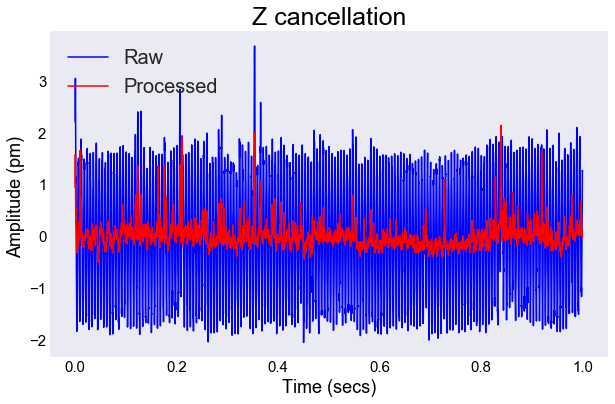

In [73]:
# plot(t,trx.create_drive(geo_cal[-10000:]-mean(geo_cut[-10000:])))
figsize(10,6)
plot(t[:10000],1e12*fit_cancel(Z_cal[-10000:]),'b',label='Raw')
plot(t[:10000],1e12*fit_cancel(Z_cal[-10000:])-1e12*trx.create_drive(geo_cal[-10000:]-mean(geo_cut[-10000:])),'r',label='Processed')

color= 'k'
tick_params(labelsize=15,colors=color)
title('Z cancellation',size=25,color=color)
xlabel('Time (secs)',size=18,color=color)
ylabel('Amplitude (pm) ',size=18,color=color)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
savefig('Z position vector cancellation',transparent=True)

In [74]:
rms_raw = sqrt(mean(fit_cancel(Z_cal[-100000:])**2))
rms_processed = sqrt(mean((fit_cancel(Z_cal[-100000:])-trx.create_drive(geo_cal[-100000:]-mean(geo_cut[-10000:])))**2))
print(around(100-100*absolute(rms_processed/rms_raw),2),'% cancellation')

75.94 % cancellation


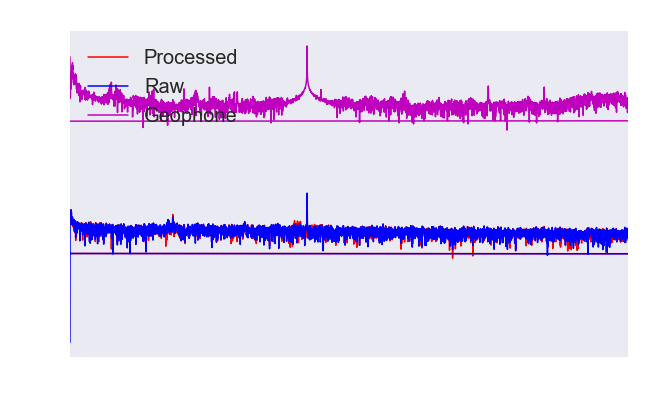

In [75]:
fft_Z = np.fft.fft(fit_cancel(Z_cal[-100000:]))
fft_Z_cancelled = np.fft.fft(fit_cancel(Z_cal[-100000:])-trx.create_drive(geo_cal[-100000:]-mean(geo_cut[-10000:])))
fft_geo = np.fft.fft(geo_cal[-100000:])
freqs_cal = np.fft.fftfreq(100000,1/10000)
semilogy(freqs_cal,absolute(fft_Z_cancelled),'r',label='Processed')
semilogy(freqs_cal,absolute(fft_Z),'b',label='Raw')
semilogy(freqs_cal,absolute(fft_geo),'m',label='Geophone')
xlim(0,400)
# ylim(1e-12,1e-7)
color ='w'
tick_params(labelsize=15,colors=color)
title('Z cancellation',size=25,color=color)
xlabel('Frequency (Hz)',size=20,color=color)
ylabel('Amplitude  ',size=20,color=color)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
# savefig('Z position vector cancellation fft',transparent=True)

In [76]:
# plot(LIY_cal)
# xlim(0,100000)

In [77]:
z_noise = trx.create_drive(geo_cut-mean(geo_cut))
kappa = -1.55555e10
cur_noise = exp(-kappa*(z_noise-mean(z_noise)))

No handles with labels found to put in legend.


7777400 94405 94405


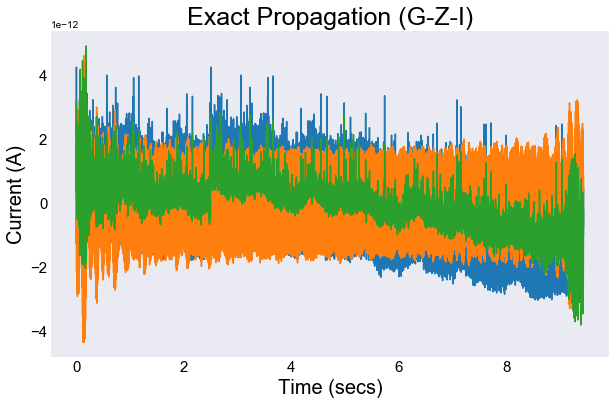

In [113]:
print(len(t),len(Z_cut),len(z_noise))
plot(t[:len(Z_cut)],Z_cut-mean(Z_cut))
plot(t[:len(z_noise)],z_noise-mean(z_noise))
plot(t[:len(z_noise)],Z_cut-mean(Z_cut)-(z_noise-mean(z_noise)))
color= 'k'
tick_params(labelsize=15,colors=color)
title('Exact Propagation (G-Z-I)',size=25,color=color)
xlabel('Time (secs)',size=20,color=color)
ylabel('Current (A)',size=20,color=color)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
# savefig('IV curve cancellation',transparent=True)

(0, 200)

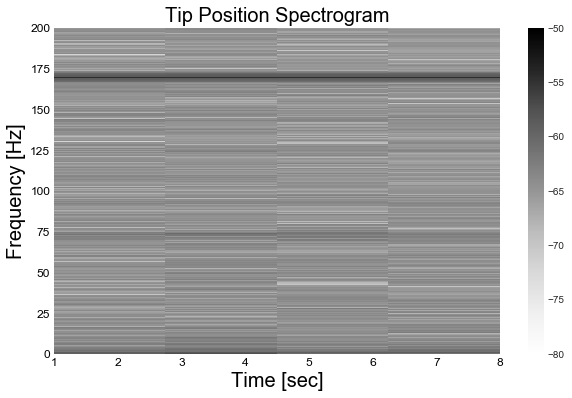

In [114]:
fig,ax =subplots(1,1,figsize=(10,6))
fs = 10000
f, t, Sxx = signal.spectrogram(fit_cancel(Z_cut), fs,nperseg=20000)
im1 = ax.pcolormesh(t,f,log(Sxx),vmin=-80,vmax=-50)#,vmin=1e-36,vmax = 1e-18)
colors= 'k'
fig.colorbar(im1)
tick_params(labelsize=12,colors=colors)
ax.set_title('Tip Position Spectrogram',size=20,color=colors)
ax.set_ylabel('Frequency [Hz]',size=20,color=colors)
ax.set_xlabel('Time [sec]',size=20,color=colors)
ax.set_ylim(0,200)

94405


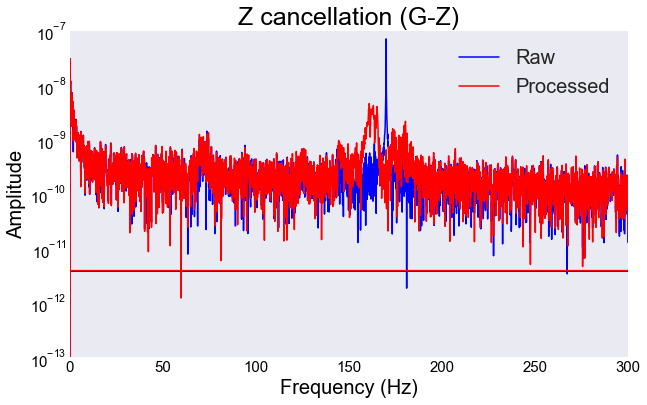

In [141]:
Z_fft = np.fft.fft(Z_cut-mean(Z_cut))
print(len(Z_cut))
Z_noise_fft = np.fft.fft(z_noise-mean(z_noise))
Z_sig_fft = np.fft.fft(Z_cut-mean(Z_cut)-(z_noise-mean(z_noise)))
freqs_sweep = np.fft.fftfreq(len(Z_cut),1/10000)

semilogy(freqs_sweep,absolute(Z_fft),'b',label='Raw')
semilogy(freqs_sweep,absolute(Z_sig_fft),'r',label='Processed')
# semilogy(freqs_sweep,1e-1*absolute(Z_noise_fft),'k',label='Noise')
xlim(0,300)
ylim(1e-13,1e-7)
color= 'k'
tick_params(labelsize=15,colors=color)
title('Z cancellation (G-Z)',size=25,color=color)
xlabel('Frequency (Hz)',size=20,color=color)
ylabel('Amplitude',size=20,color=color)
leg = legend(loc=1, fontsize = 20,fancybox=True, framealpha=0)
# savefig('IV curve cancellation fft',transparent=True)

In [10]:
cur_sig = fit_cancel(cur_cut)/cur_noise
print(shape(cur_cut),shape(cur_noise))

NameError: name 'fit_cancel' is not defined

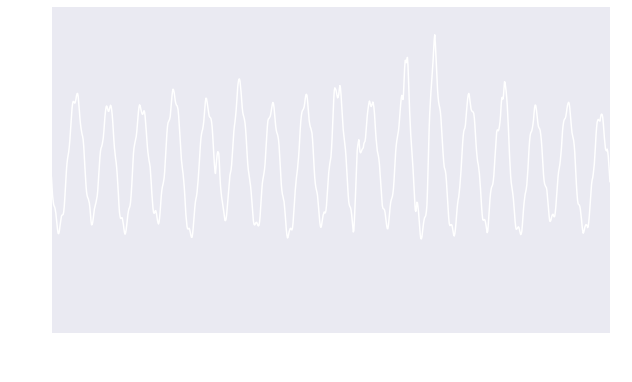

In [41]:
plt.rcParams.update({'font.size': 16})
# plot(t[:len(cur_sig)],Z_cut,)
# plot(t[:len(cur_sig)],cur_cut)
# color= 'k'
# tick_params(labelsize=15,colors=color)
# title('Current Noise',size=25,color=color)
# xlabel('Time (secs)',size=20,color=color)
# ylabel('Current ',size=20,color=color)

fig, ax1 = plt.subplots(1,1,figsize=(10,6))

color = 'tab:red'


ax1.set_xlabel('Time (s)',size=20,color='w')
ax1.set_ylabel('Z position (pm)',size=20, color='w')
ax1.plot(t[:len(cur_cut)], 1e12*real(Z_cut-mean(Z_cut)), color='w')
ax1.tick_params(axis='y', labelcolor='w')
xlim(1,1.1)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('Current (nA)',size=20, color='w')  # we already handled the x-label with ax1
# ax2.plot(t[:len(cur_cut)], 1e9*cur_cut, color='#ffc000')
# ax2.tick_params(axis='y', labelcolor='w')
ax1.tick_params(axis='x',labelcolor='w')
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# leg = ax1legend(['Z position','Current'],loc=2, fontsize = 20,fancybox=True, framealpha=0)
# for text in leg.get_texts():
#     plt.setp(text, color = 'k')
# plt.show()
savefig('Z-Cur phase dif',transparent=True)

No handles with labels found to put in legend.


(0, 0.1)

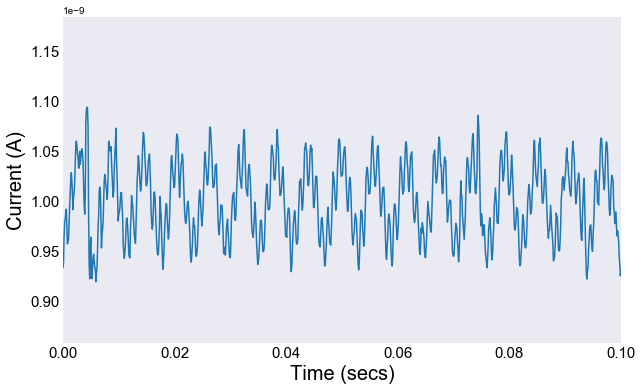

In [93]:
plot(t[:len(cur_sig)],cur_cut)
color= 'k'
tick_params(labelsize=15,colors=color)
# title('Current',size=25,color=color)
xlabel('Time (secs)',size=20,color=color)
ylabel('Current (A)',size=20,color=color)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
xlim(0,0.1)

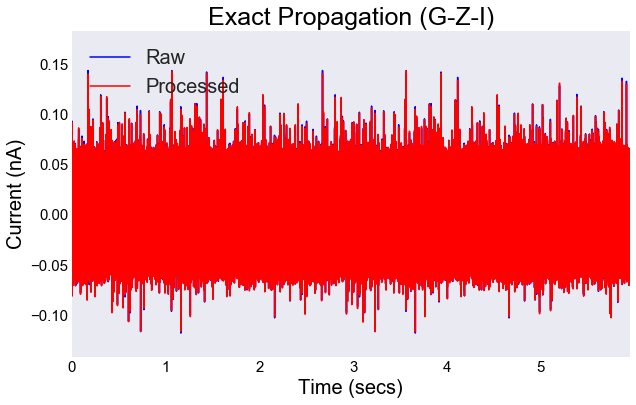

In [94]:
plot(t[:len(cur_cut)],fit_cancel(cur_cut)*1e9,'b',label='Raw')
plot(t[:len(cur_sig)],cur_sig*1e9,'r',label='Processed')
xlim(0,5.95)
# ylim(-0.1e-9,1.5e-9)
color= 'k'
tick_params(labelsize=15,colors=color)
title('Exact Propagation (G-Z-I)',size=25,color=color)
xlabel('Time (secs)',size=20,color=color)
ylabel('Current (nA)',size=20,color=color)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
# savefig('IV curve cancellation',transparent=True)

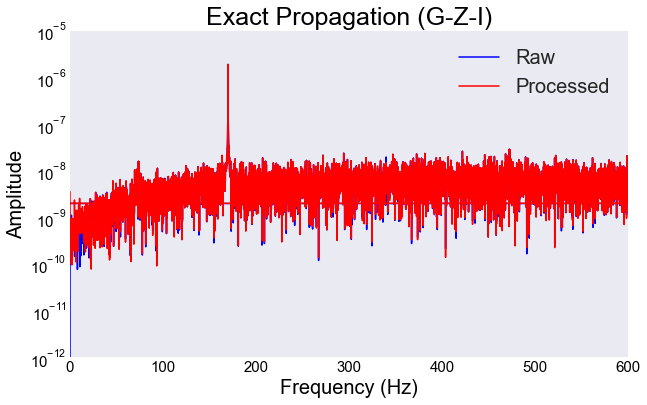

In [95]:
cur_fft = np.fft.fft(fit_cancel(cur_cut))
cur_sig_fft = np.fft.fft(cur_sig)
cur_noise_fft = np.fft.fft(cur_noise)
freqs = np.fft.fftfreq(len(cur_cut),1/10000)
semilogy(freqs,absolute(cur_fft),'b',label='Raw')
semilogy(freqs,absolute(cur_sig_fft),'r',label='Processed')

# semilogy(freqs,absolute(cur_noise_fft),'m',label='Noise')

xlim(0,600)
ylim(1e-12,1e-5)
color= 'k'
tick_params(labelsize=15,colors=color)
title('Exact Propagation (G-Z-I)',size=25,color=color)
xlabel('Frequency (Hz)',size=20,color=color)
ylabel('Amplitude',size=20,color=color)
leg = legend(loc=1, fontsize = 20,fancybox=True, framealpha=0)

(0, 0.1)

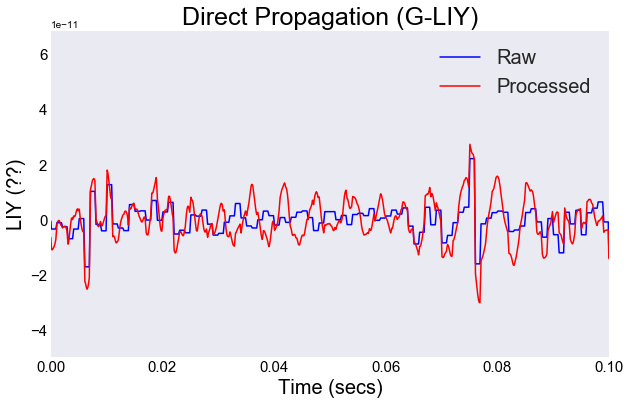

In [97]:
LIY_sig = fit_cancel(LIY_cut) - trx_liy.create_drive(geo_cut-mean(geo_cut))*(mean(cur_cut)/1e-9)
plot(t[:len(LIY_cut)],fit_cancel(LIY_cut),'b',label='Raw')
plot(t[:len(LIY_sig)],LIY_sig,'r',label='Processed')
color= 'k'
tick_params(labelsize=15,colors=color)
title('Direct Propagation (G-LIY)',size=25,color=color)
xlabel('Time (secs)',size=20,color=color)
ylabel('LIY (??)',size=20,color=color)
leg = legend(loc=1, fontsize = 20,fancybox=True, framealpha=0)
xlim(0,0.1)

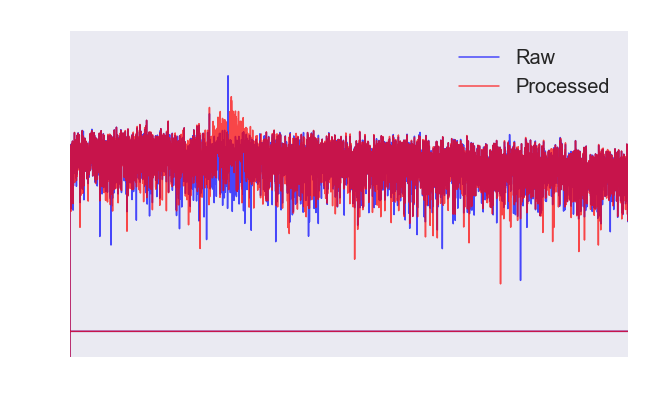

In [98]:
liy_fft = np.fft.fft(fit_cancel(LIY_cut))
liy_sig_fft = np.fft.fft(LIY_sig)
freqs= np.fft.fftfreq(len(LIY_cut),1/10000)
semilogy(freqs,absolute(liy_fft),'b',label='Raw',alpha=0.7)
semilogy(freqs,absolute(liy_sig_fft),'r',label='Processed',alpha=0.7)
xlim(0,600)
ylim(1e-12,1e-6)
color= 'w'
tick_params(labelsize=15,colors=color)
title('Direct Propagation',size=25,color=color)
xlabel('Frequency (Hz)',size=20,color=color)
ylabel('Amplitude',size=20,color=color)
leg = legend(loc=1, fontsize = 20,fancybox=True, framealpha=0)

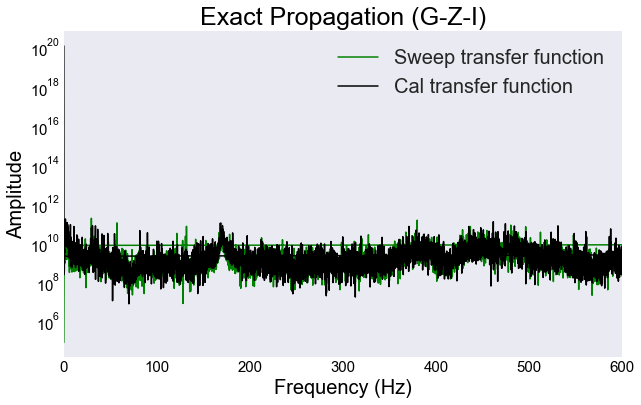

In [112]:
# sweep_fft = np.fft.fft(cur_cut*1e12)
# sweep_fft_cancelled = np.fft.fft(cur_sig)
# sweep_fft_noise = np.fft.fft(cur_noise)
geo_fft = np.fft.fft(geo_cut[:80000])
sw_z_fft = np.fft.fft(Z_cut[:80000])
freqs_sweep = np.fft.fftfreq(len(cur_cut[:80000]),1/10000)
# semilogy(freqs_sweep,absolute(sweep_fft),'b',label='Raw')
semilogy(freqs_cal,absolute(fft_geo/len(fft_geo)),'g',label='Geophone cal')
semilogy(freqs_sweep,absolute(geo_fft),'k',label='Geophone sweep')


# semilogy(freqs_sweep,absolute(sw_z_fft),'b',label='Z sweep')
# semilogy(freqs_cal,absolute(fft_Z),'r',label='Z cal')

# semilogy(freqs_sweep,absolute(geo_fft/sw_z_fft),'g',label='Sweep transfer function')
# semilogy(freqs_cal,absolute(fft_geo/fft_Z),'k',label='Cal transfer function')
# semilogy(freqs_sweep,absolute(sweep_fft_cancelled),'r',label='Processed')
# semilogy(freqs_sweep,absolute(sweep_fft_noise),'m',label='Noise')
xlim(0,600)
# ylim(1e6,1e13)
color= 'k'
tick_params(labelsize=15,colors=color)
title('Exact Propagation (G-Z-I)',size=25,color=color)
xlabel('Frequency (Hz)',size=20,color=color)
ylabel('Amplitude',size=20,color=color)
leg = legend(loc=1, fontsize = 20,fancybox=True, framealpha=0)
# savefig('IV curve cancellation fft',transparent=True)


In [498]:
start = brk_pnt[0]+3
end = brk_pnt[-1]+2

cur_cut = dat_spec[start:end,0]
geo_cut = dat_spec[start:end,1]
speaker_cut = dat_spec[start:end,2]
bias_mod_cut = dat_spec[start:end,4]
bias_cut = dat_spec[start:end,5]
Z_cut = dat_spec[start:end,8]
LIY_cut = dat_spec[start:end,10]

t = linspace(0,len(cur_cut)/10000,len(cur_cut))
print(len(cur_cut),len(t))

2373622 2373622


In [327]:
# trx = cancel.Cancel(geo_cal-mean(geo_cal),LIY_cal,1/10000,p=[200000,150000,5])
# LIY_noise = stmpy.tools.butter_lowpass_filter(trx.create_drive(geo_cut-mean(geo_cut)), ncutoff=300/10000)  

In [328]:
# plot(t,LIY_cut)
# plot(t,LIY_noise)
# plot(t,LIY_cut-LIY_noise)

322 322


(-5, 100)

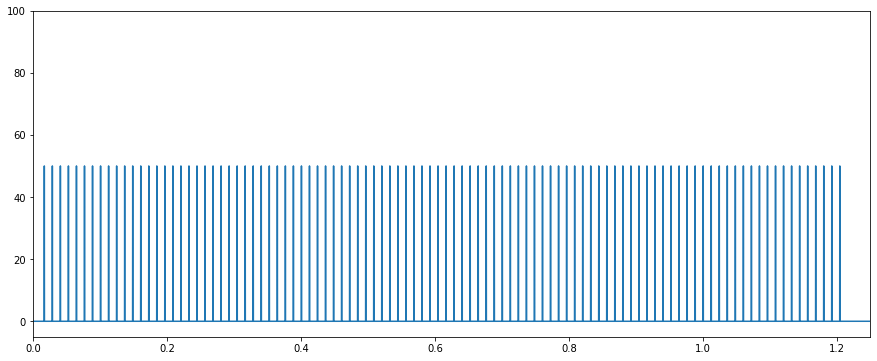

In [329]:
figsize(15,6)
dt = t[1]
grad = np.gradient(bias_cut,dt)
swp_pnt = np.argsort(grad)[:322]
count = 0
for j in swp_pnt:
    if grad[j] < -1000:
        count = count+1
print(count,len(swp_pnt))
swp_pnt = (np.sort(swp_pnt))
swp_pnt = swp_pnt[:322]
plot(t[swp_pnt],grad[swp_pnt],'r.')
# plot(t,bias_cut)
plot(t,grad)
start = 0
xlim(start,start+1.25)
ylim(-5,100)

200
[  168   288   408   528   648   768   888  1008  1128  1248  1368  1488
  1608  1728  1848  1968  2088  2208  2328  2448  2568  2688  2808  2928
  3048  3168  3288  3408  3528  3648  3768  3888  4008  4128  4248  4368
  4488  4608  4728  4848  4968  5088  5208  5328  5448  5568  5688  5808
  5928  6048  6168  6288  6408  6528  6648  6768  6888  7008  7128  7248
  7368  7488  7608  7728  7848  7968  8088  8208  8328  8448  8568  8688
  8808  8928  9048  9168  9288  9408  9528  9648  9768  9888 10008 10128
 10248 10368 10488 10608 10728 10848 10968 11088 11208 11328 11448 11568
 11688 11808 11928 12048 14739]


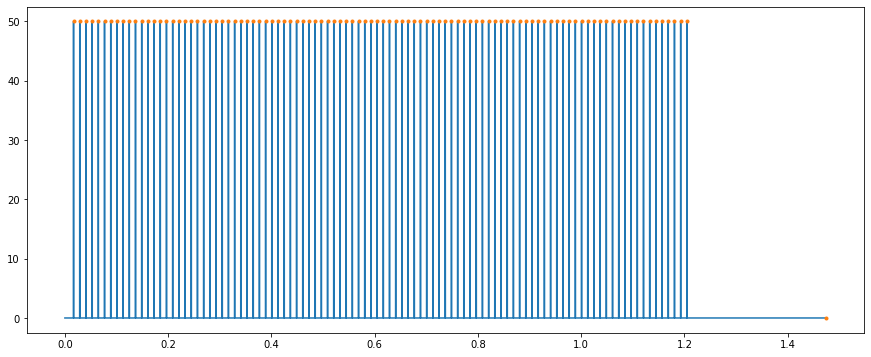

In [330]:
prev = 0
for brk in swp_pnt:
    grad_brk = grad[prev:brk]
    brk_pnt_2 = np.flip(np.argsort(grad_brk))[:200]
    brk_pnt_2 = (np.sort(brk_pnt_2))
    
    count = 0
    for j in brk_pnt_2:
        if grad_brk[j] > 20:
            count = count+1
    print(count)
#     plot(t[prev:brk],grad_brk)
#     plot(t[brk_pnt_2],grad_brk[brk_pnt_2],'.')
#     xlim(0,0.2)
    break

step_pnt = np.flip(np.argsort(grad_brk))[:200]
step_pnt = -np.sort(-step_pnt)
# print(brk_pnt)
for idx,point in enumerate(step_pnt):
    temp_pnt = point
    step_pnt[np.where(absolute(step_pnt-point)<10)] = 0
    step_pnt[idx] = point
step_pnt = np.sort(step_pnt[step_pnt != 0])
step_pnt = np.append(step_pnt,len(grad_brk)-1)
plot(t[prev:brk],grad_brk)
plot(t[step_pnt],grad_brk[step_pnt],'.')
print(step_pnt)

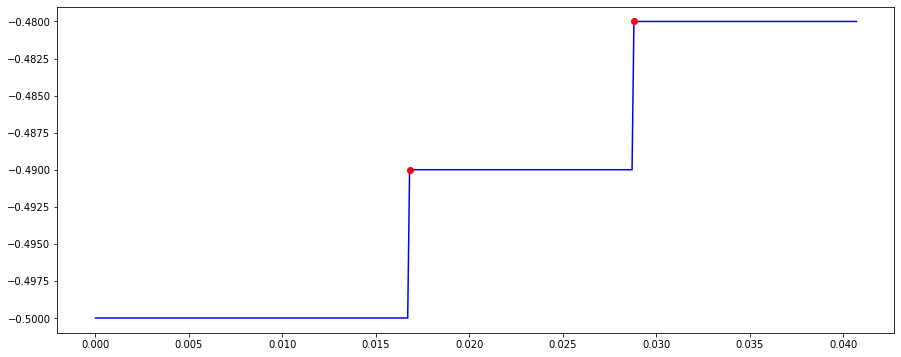

In [331]:

plot(t[:step_pnt[2]],bias_cut[:step_pnt[2]],'b')
plot(t[step_pnt[:2]],bias_cut[step_pnt[:2]],'ro')

In [336]:
prev = 0 

I_n = np.zeros(len(step_pnt))
reps = np.zeros(len(step_pnt))
for idx,point in enumerate(step_pnt):
    I_n[idx] = mean(cur_cut[prev:point])
    reps[idx] = point-prev
    prev = point
reps[-1] = reps[-1] +1
print(len(I_n),reps.astype('int'))
print(I_n)
I_n = repeat(I_n,reps.astype('int'))

print(len(cur_cut[:brk]),len(I_n),I_n[0])

101 [ 168  120  120  120  120  120  120  120  120  120  120  120  120  120
  120  120  120  120  120  120  120  120  120  120  120  120  120  120
  120  120  120  120  120  120  120  120  120  120  120  120  120  120
  120  120  120  120  120  120  120  120  120  120  120  120  120  120
  120  120  120  120  120  120  120  120  120  120  120  120  120  120
  120  120  120  120  120  120  120  120  120  120  120  120  120  120
  120  120  120  120  120  120  120  120  120  120  120  120  120  120
  120  120 2692]
[-9.16483795e-10 -8.82052226e-10 -8.53386850e-10 -8.70552504e-10
 -8.65492530e-10 -8.08995348e-10 -8.42980546e-10 -7.94745347e-10
 -7.68545221e-10 -7.54153843e-10 -7.40399829e-10 -7.31431634e-10
 -7.20958217e-10 -7.06839994e-10 -6.84963177e-10 -6.74538487e-10
 -6.56323833e-10 -6.38290247e-10 -6.23266016e-10 -6.41146836e-10
 -5.91953999e-10 -5.71406034e-10 -5.54696767e-10 -5.44373027e-10
 -5.23110222e-10 -5.00490787e-10 -4.82821338e-10 -4.64151017e-10
 -4.45038310e-10 -4.2897338

No handles with labels found to put in legend.


(0, 5e-10)

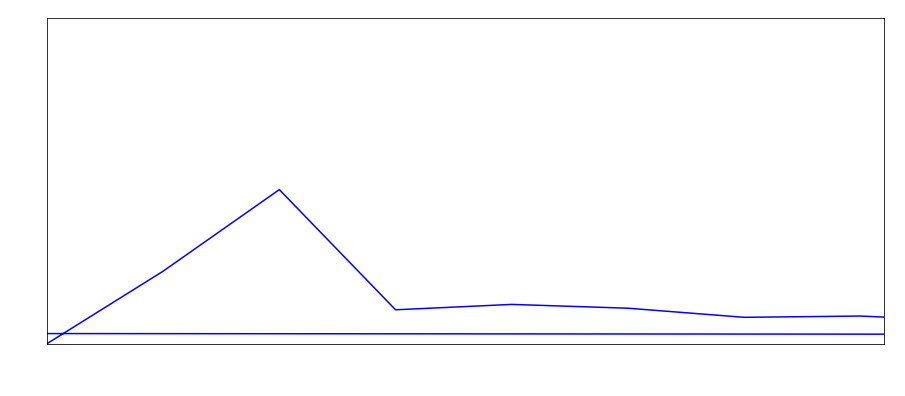

In [508]:
cur_step = np.fft.fft(fit_cancel(cur_cut[step_pnt[53]:step_pnt[54]]))
freq_step = np.fft.fftfreq(len(cur_step),1/10000)
# plot(cur_cut[step_pnt[50]:step_pnt[51]])
plot(freq_step,absolute(cur_step),'b')
color= 'w'
tick_params(labelsize=15,colors=color)
# title('Initial current calculation',size=25,color=color)
xlabel('Frequency (Hz)',size=20,color=color)
ylabel('',size=20,color=color)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
xlim(0,600)
ylim(0,0.5e-9)

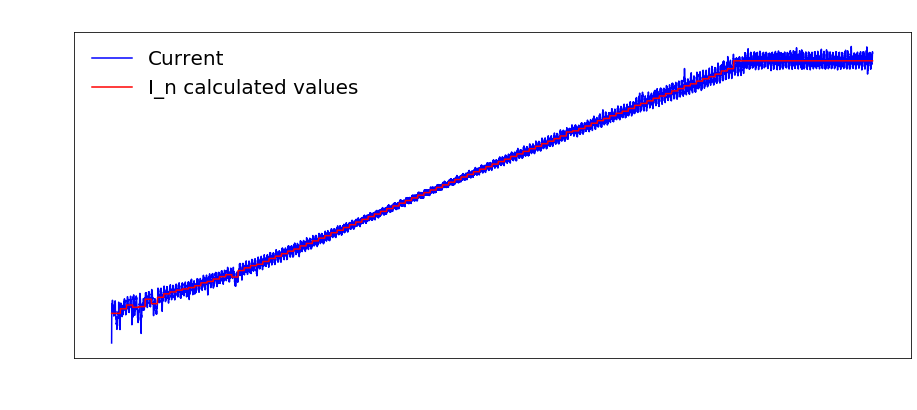

In [344]:
plot(t[:brk],cur_cut[:brk],'b',label='Current')
plot(t[:brk],I_n,'r',label='I_n calculated values')
color= 'w'
tick_params(labelsize=15,colors=color)
title('Initial current calculation',size=25,color=color)
xlabel('Time (secs)',size=20,color=color)
ylabel('Current (A)',size=20,color=color)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)

In [351]:
trx = cancel.Cancel(geo_cal-mean(geo_cal),fit_cancel(LIY_cal),1/10000,p=[200000,50000,5])
# LIY_noise = stmpy.tools.butter_lowpass_filter(trx.create_drive(geo_cut[:brk]-mean(geo_cut[:brk])), ncutoff=300/10000)  

In [387]:
# LIY_fft = np.fft.fft(fit_cancel(LIY_cal))
# freqs = np.fft.fftfreq(len(LIY_cal),1/10000)
# plot(freqs,absolute(LIY_fft))
# xlim(0,600)

In [474]:
I_0 = 1e-9
LIY_noise = I_n*stmpy.tools.butter_lowpass_filter((1/I_0)*trx.create_drive(geo_cut[:brk]-mean(geo_cut[:brk])),ncutoff=600/10000)

(1.19280050252336, 1.5)

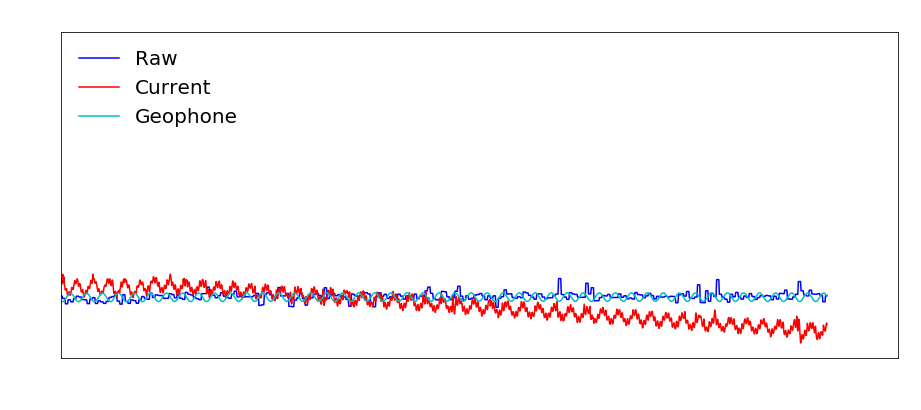

In [524]:
LIY_sig = fit_cancel(LIY_cut[:brk])-LIY_noise
plot(t[:brk],5e9*fit_cancel(LIY_cut[:brk]),'b',label='Raw')
plot(t[:brk],1e9*fit_cancel(cur_cut[:brk]),'r',label='Current')
plot(t[:brk],fit_cancel(geo_cut[:brk]),'c',label='Geophone')
# plot(t[:brk],LIY_sig*1e12,'r',label='Processed')
# plot(t[step_pnt],1e-10+0*LIY_cut[step_pnt],'.')
color= 'w'
tick_params(labelsize=15,colors=color)
title('Initial current calculation',size=25,color=color)
xlabel('Time (secs)',size=20,color=color)
ylabel('LIY (nA)',size=20,color=color)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
xlim(t[step_pnt[-3]],1.5)
# ylim(-20,20)

(0, 600)

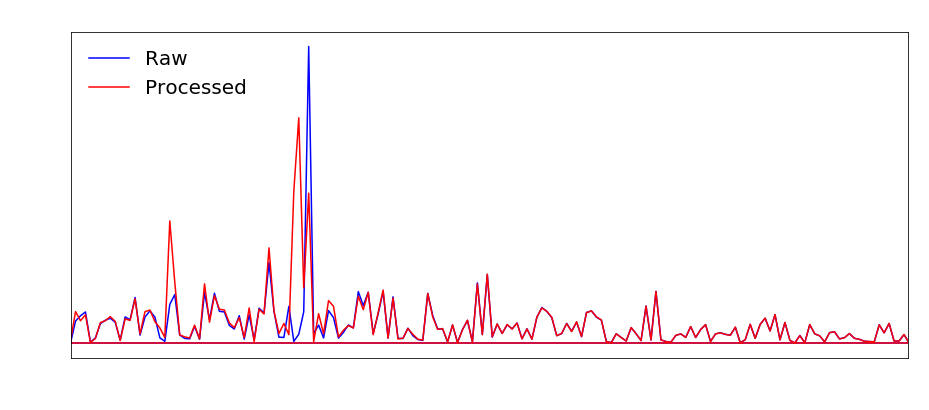

In [480]:
LIY_fft = np.fft.fft(1e12*fit_cancel(LIY_cut[step_pnt[-3]:brk]))
LIY_sig_fft = np.fft.fft(1e12*LIY_sig[step_pnt[-3]:])
freqs = np.fft.fftfreq(len(LIY_cut[step_pnt[-3]:brk]),1/10000)

plot(freqs,absolute(LIY_fft)**2,'b',label='Raw')
plot(freqs,absolute(LIY_sig_fft)**2,'r',label='Processed')

color= 'w'
tick_params(labelsize=15,colors=color)
title('Initial current calculation',size=25,color=color)
xlabel('Frequency (Hz)',size=20,color=color)
ylabel('LIY (pA^2/Hz)',size=20,color=color)
leg = legend(loc=2, fontsize = 20,fancybox=True, framealpha=0)
xlim(0,600)

In [461]:
# plot(LIY_cut)